# Application sur un dataset d'images couleur

In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

## CIFAR-10

Dans cette application, nous allons utiliser le dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) qui regroupe 60 000 images couleurs de taille $3 \times 32 \times 32$ appartenant à 10 classes.  
Les classes sont les suivantes : airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.  
Nous allons utiliser torchvision pour charger le dataset : 

In [2]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Transformation des données, normalisation et transformation en tensor pytorch
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Téléchargement et chargement du dataset
dataset = torchvision.datasets.CIFAR10(root='./../data', train=True,download=True, transform=transform)
testdataset = torchvision.datasets.CIFAR10(root='./../data', train=False,download=True, transform=transform)
print("taille d'une image : ",dataset[0][0].shape)

#Création des dataloaders pour le train, validation et test
train_dataset, val_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,shuffle=True, num_workers=2)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:16<00:00, 10377820.68it/s]


Extracting ./../data/cifar-10-python.tar.gz to ./../data
Files already downloaded and verified
taille d'une image :  torch.Size([3, 32, 32])


On peut visualiser les images et les classes : 

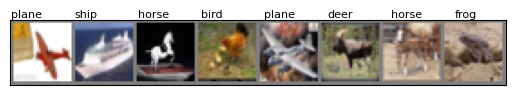

In [3]:
def imshow_with_labels(img, labels):
  img = img / 2 + 0.5  # Dénormaliser
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.xticks([])  # Supprimer les graduations sur l'axe des x
  plt.yticks([])  # Supprimer les graduations sur l'axe des y
  for i in range(len(labels)):
    plt.text(i * 35, -2, classes[labels[i]], color='black', fontsize=8, ha='left')

# Récupération d'un batch d'images
images, labels = next(iter(train_loader))

# Affichage des images avec leurs classes
imshow_with_labels(torchvision.utils.make_grid(images[:8]), labels[:8])
plt.show()

## Création d'un réseau convolutif pour ce problème

Dans le cours sur la couche de convolution, nous avons introduit le paramètre stride qui correspond au pas de la convolution. Avec un pas de 2, l'image aura une résolution divisé par deux à la fin de l'opération de convolution (sous réserve que le padding compense la taille du filtre). On voit donc que l'opération de pooling peut être "remplacé" par l'augmentation du stride. La sortie d'une couche de convolution de stride 1 suivie d'une couche de pooling sera de même dimension que la sortie d'une couche de convolution de stride 2 sans couche de pooling.  
Dans cette application, nous allons donc remplacer nos couches de pooling par une augmentation du stride de nos convolutions.  
Pour en savoir plus, vous pouvez consulter le [blogpost](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Difference-Between-Strided-Convolution-and-Pooling---VmlldzoyMDE5Mjc) ou l'[article](https://arxiv.org/abs/1412.6806).

In [4]:
class cnn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=nn.Conv2d(3,8,kernel_size=3,stride=2,padding=1)
    self.conv2=nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)
    self.conv3=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1)
    self.fc=nn.Linear(4*4*32,10)
  
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,4*4*32)
    output=self.fc(x)
    return output

In [5]:
model = cnn() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Nombre de paramètres 11162


## Entraînement du modèle

In [6]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 1.5988761186599731
step 0 val loss 1.4532517194747925
step 1 train loss 1.3778905868530273
step 1 val loss 1.3579093217849731
step 2 train loss 1.2898519039154053
step 2 val loss 1.2919617891311646
step 3 train loss 1.2295998334884644
step 3 val loss 1.256637692451477
step 4 train loss 1.186734914779663
step 4 val loss 1.240902304649353


In [8]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  55.92


### GPU

Si vous disposez d'un GPU sur votre ordinateur ou que vous avez accès à un GPU par un service CLOUD, vous pouvez accélerer l'entraînement de votre modèle ainsi que l'inférence.  
Voici comment faire en pytorch : 

In [9]:
model = cnn().to('cuda') # Ajouter le .to('cuda') pour charger le modèle sur GPU

In [10]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [11]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    images=images.to('cuda') # Ajouter le .to('cuda') pour charger les images sur GPU
    labels=labels.to('cuda') # Ajouter le .to('cuda') pour charger les labels sur GPU
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad():
      images=images.to('cuda')
      labels=labels.to('cuda')
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


step 0 train loss 1.6380540132522583
step 0 val loss 1.4465171098709106
step 1 train loss 1.369913101196289
step 1 val loss 1.3735681772232056
step 2 train loss 1.2817057371139526
step 2 val loss 1.2942956686019897
step 3 train loss 1.2238909006118774
step 3 val loss 1.2601954936981201
step 4 train loss 1.186323881149292
step 4 val loss 1.2583365440368652


In [12]:
correct = 0
total = 0
for images,labels in test_loader: 
  images=images.to('cuda')
  labels=labels.to('cuda')
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  55.76


En fonction de votre GPU, vous avez sans doute constaté une augmentation de la vitesse d'entraînement et d'inférence du modèle. Cette différence de vitesse devient très importante lorsqu'on utilise des GPU très puissants sur des modèles très profonds. 

### Exercice à faire 

Pour s'exercer, vous pouvez essayer d'améliorer les performances du modèle sur le dataset CIFAR-10. Vous pouvez augmenter le nombre de couches, changer le nombre de filtres des couches, ajouter du dropout, utiliser la batchnorm, augmenter le nombre d'epochs d'entraînement, changer le learning rate etc ...   
Essayer d'atteindre au moins 70% de précision. 
